## **Spatial Clustering and Classification of Molecular Localizations Using MIRO**

This tutorial demonstrates how to train and apply **MIRO** for the simultaneous clustering and classification of spatial point clouds from single-molecule localization microscopy (SMLM).


In [ ]:
import sys
from pathlib import Path

# Ensure the library path is in sys.path
lib_path = Path.cwd().parent.resolve()

if str(lib_path) not in sys.path:
    sys.path.insert(0, str(lib_path))

import lib

### **1. Load the Data**

To begin, load the training data.

It consists of pre-generated synthetic images containing mixtures of circular and elliptical clusters. Each cluster type represents a distinct molecular assembly, characterized by its own spatial geometry and scale.


In [2]:
import pandas as pd

training_data = pd.read_csv("data/training_data.csv")

### **2. Build the training dataset**


Next, we create the training dataset by converting each synthetic image into a graph-based representation compatible with **MIRO**. The code snippet below demonstrates how to build a custom data loader tailored to this multishape setting.

The `MultishapeGraphDataset` class reads each training image and constructs a graph where nodes represent individual molecular localizations, and edges are defined using Delaunay triangulation. These edges are then filtered using a specified `connectivity_radius` to retain only meaningful local connections.

For each image, the loader returns a `torch_geometric.data.Data` object containing the graph structure, positional features, ground-truth displacement vectors, and node-wise shape labels. These data objects serve as the input to the **MIRO** model during training.

In [3]:
import numpy as np
import matplotlib.tri as tri
import itertools
import tqdm

import torch
from torch_geometric.transforms import AddLaplacianEigenvectorPE
from torch_geometric.data import Data


class MultishapeGraphDataset:
    def __init__(
        self,
        training_images,
        connectivity_radius=1,
    ):
        self.training_images = training_images
        self.connectivity_radius = connectivity_radius

        self.laplacian_embedding = AddLaplacianEigenvectorPE(
            5, attr_name="x", is_undirected=True
        )

    def __call__(self):
        return self.generate_dataset()

    def generate_dataset(self):
        """Generate a dataset of graph-structured data."""
        dataset = []
        for _, df_set in tqdm.tqdm_notebook(
            self.training_images.groupby("set", sort=False),
            desc="Generating dataset",
        ):
            positions = df_set[["x", "y"]].to_numpy()
            deltas = df_set[["dx", "dy"]].to_numpy()
            classes = df_set["class"].to_numpy()

            data = self.create_data_object(positions, deltas, classes)
            dataset.append(data)

        return dataset

    def create_data_object(self, positions, deltas, classes):
        """Create a `Data` object from positions and deltas."""
        data = Data()

        # Prepare ground truth displacements
        data.y, data.y_class = (
            torch.tensor(deltas, dtype=torch.float) / self.connectivity_radius,
            torch.tensor(classes, dtype=torch.long),
        )

        # Add graph structure
        data.edge_index, data.edge_attr = self.compute_connectivity(positions)
        data.num_nodes = positions.shape[0]

        # Add positional and embedding features
        data = self.laplacian_embedding(data)
        data.x = torch.abs(data.x)
        data.position = torch.tensor(positions, dtype=torch.float)

        return data

    def compute_connectivity(self, positions):
        """Compute the connectivity graph and edge attributes."""
        delaunay = tri.Triangulation(positions[:, 0], positions[:, 1])
        edges = self.extract_edges(delaunay.triangles)

        distances, displacements = self.compute_edge_metrics(edges, positions)
        valid_mask = distances < self.connectivity_radius

        edges = edges[valid_mask]
        distances = distances[valid_mask, None]
        displacements = displacements[valid_mask]

        edges, displacements, distances = self.make_graph_undirected(
            edges, displacements, distances
        )

        edge_index, edge_attr = self.format_edges_and_attributes(
            edges, displacements, distances
        )
        return edge_index, edge_attr

    @staticmethod
    def extract_edges(triangles):
        """Extract edges from triangles."""
        edges = [
            np.array(list(itertools.combinations(triangle, r=2)))[[1, 0, 2]]
            for triangle in triangles
        ]
        return np.concatenate(edges, axis=0)

    @staticmethod
    def compute_edge_metrics(edges, positions):
        """Compute displacements and distances for edges."""
        displacements = positions[edges[:, 0]] - positions[edges[:, 1]]
        distances = np.linalg.norm(displacements, axis=1)
        return distances, displacements

    @staticmethod
    def make_graph_undirected(edges, displacements, distances):
        """Ensure the graph is undirected by mirroring edges."""
        edges = np.concatenate([edges, edges[:, [1, 0]]], axis=0)
        displacements = np.concatenate([displacements, -displacements], axis=0)
        distances = np.concatenate([distances, distances], axis=0)

        # Remove duplicate edges
        unique_edges, indices = np.unique(edges, axis=0, return_index=True)
        return unique_edges, displacements[indices], distances[indices]

    def format_edges_and_attributes(self, edges, displacements, distances):
        """Format edges and their attributes for PyTorch Geometric."""
        edge_index = torch.tensor(edges.T, dtype=torch.long)
        edge_attr = (
            torch.cat(
                [
                    torch.tensor(displacements, dtype=torch.float),
                    torch.tensor(distances, dtype=torch.float),
                ],
                dim=1,
            )
            / self.connectivity_radius
        )
        return edge_index, edge_attr

Now, instantiate the dataset builder and generate the training dataset.

In [ ]:
builder = MultishapeGraphDataset(
    training_data,
    connectivity_radius=0.2,
)
training_dataset = builder()

Let’s take a closer look at one of the training samples.

From left to right, we visualize the graph representation, the displacement vectors pointing from each node to its assigned cluster center, and the ground truth shape labels, where each node is colored according to the class of the cluster it belongs to (e.g., circular or elliptical).


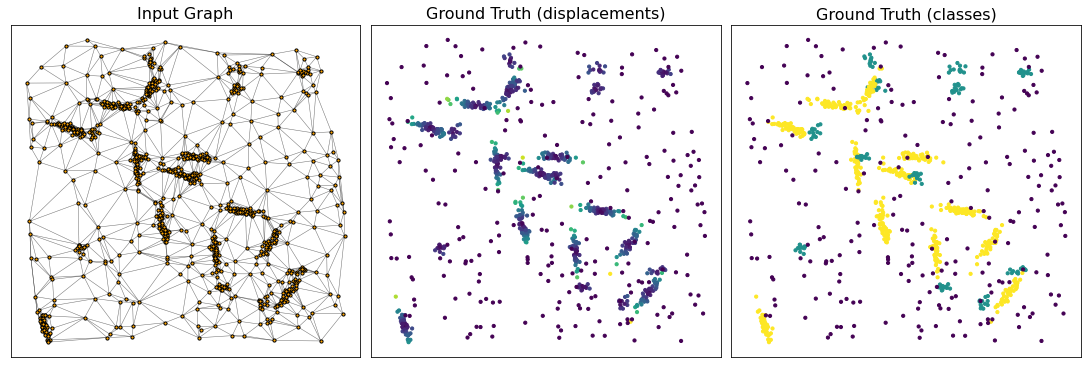

In [5]:
import numpy as np
import random

import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection

def plot_training_data(data, figsize=(15, 5), titles=None):
    pos = data["position"]        
    edges = data["edge_index"].T  
    values = [                    
        None,
        np.linalg.norm(data["y"], axis=1),
        data["y_class"]
    ]

    titles = titles or [
        "Input Graph",
        "Ground Truth (displacements)",
        "Ground Truth (classes)",
    ]

    fig, axes = plt.subplots(1, 3, figsize=figsize, constrained_layout=True)

    for i, ax in enumerate(axes):
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(titles[i], fontsize=16)

        if i == 0:
            segments = pos[edges]
            lc = LineCollection(segments, colors="black",
                                linewidths=0.5, alpha=0.3)
            ax.add_collection(lc)
            ax.scatter(pos[:, 0], pos[:, 1],
                       s=10, c="orange", edgecolors="black", zorder=2)
        else:
            im = ax.scatter(pos[:, 0], pos[:, 1],
                            c=values[i], s=10)

    return fig, axes


idx = random.randrange(len(training_dataset))
fig, axes = plot_training_data(training_dataset[idx])
plt.show()

### **3. Create the model**


Now, instantiate **MIRO** using a configuration that matches the training data.

The model is initialized with a set of key parameters: the number of classes (in this case, 3, corresponding to background, circular clusters, and elliptical clusters), the connectivity radius used to construct the input graphs (which should match the value used during augmentation), and the number of recurrent message-passing iterations applied to each graph (set to 20 by default).

In this configuration, the total number of output features is set to `num_classes + 2`, accounting for both the predicted *x* and *y* displacements, as well as the per-node class probabilities.


In [6]:
import deeplay as dl

clusterer = dl.cMIRO(
    num_classes=3,  # Total number of features is 2 (i.e., x, y displacements) + num_classes
    connectivity_radius=builder.connectivity_radius,  # Radius for graph connectivity (matches dataset)
    num_iterations=20,  # Number of iterations for graph processing
)
clusterer = clusterer.create()

print(clusterer)

cMIRO(
  (model): RecurrentMessagePassingModel(
    (encoder): Parallel(
      (0-1): 2 x MultiLayerPerceptron(
        (blocks): LayerList(
          (0): LinearBlock(
            (layer): LazyLinear(in_features=0, out_features=256, bias=True)
            (activation): Identity()
          )
        )
      )
    )
    (backbone): RecurrentGraphBlock(
      (combine): CatDictElements()
      (layer): Sequential(
        (0): Parallel(
          (0-1): 2 x MultiLayerPerceptron(
            (blocks): LayerList(
              (0): LinearBlock(
                (layer): LazyLinear(in_features=0, out_features=256, bias=True)
                (activation): Identity()
              )
            )
          )
        )
        (1): MessagePassingNeuralNetwork(
          (blocks): LayerList(
            (0): TransformPropagateUpdate(
              (transform): Transform(
                (combine): Cat()
                (layer): LazyLinear(in_features=0, out_features=256, bias=True)
            

### **4. Train the model**


Set up the data loaders and configure the training parameters.

In [7]:
from torch_geometric.data import DataLoader

train_loader = DataLoader(
    dataset=training_dataset,  # The dataset to be loaded
    batch_size=4,  # Number of samples per batch
    shuffle=True,  # Shuffle the dataset at every epoch
)

# Initialize the trainer
trainer = dl.Trainer(max_epochs=30)  # Maximum number of training epochs

c:\Users\Jesus\AppData\Local\Programs\Python\Python38\lib\site-packages\torch_geometric\deprecation.py:22: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)
c:\Users\Jesus\AppData\Local\Programs\Python\Python38\lib\site-packages\pkg_resources\__init__.py:116: PkgResourcesDeprecationWarning: otobuf is an invalid version and will not be supported in a future release
  warnings.warn(
c:\Users\Jesus\AppData\Local\Programs\Python\Python38\lib\site-packages\pkg_resources\__init__.py:116: PkgResourcesDeprecationWarning: 3df76a9e45e3a1d6165e42c565a2f8622f7c1f8c- is an invalid version and will not be supported in a future release
  warnings.warn(


Finally, train **MIRO**. 

Alternatively, you can load a pre-trained model by setting `train_model = False`.

In [8]:
import torch

train_model = False

if train_model:
    trainer.fit(
        clusterer,  # The MIRO model to be trained
        train_loader,  # The DataLoader providing the training data
    )
else:
    clusterer.load_state_dict(torch.load("models/checkpoint.pt"))  # Load pre-trained model weights

### **5. Test the model**


Once training is complete, it’s time to evaluate **MIRO** on the validation dataset.

The following code reads the validation set and applies the trained model to perform simultaneous clustering and classification. The `clusterer` object provides a built-in `.clustering()` method that automates the full inference pipeline. This method applies **MIRO** to each input graph, transforms the node features into a learned **squeezed representation**, where localizations belonging to the same cluster are pulled toward a common center; runs DBSCAN on this transformed space to generate final cluster assignments; and refines the predicted node-wise class labels based on the clustering results.


In [9]:
from sklearn import metrics

clusterer.eval()
clusterer.to("cuda" if torch.cuda.is_available() else "cpu")

validation_data = pd.read_csv("data/validation_data.csv")

vresults = []
for s in validation_data["set"].unique():
    vdata = validation_data[validation_data["set"] == s].copy()
    val_graph = lib.compute_test_graph(vdata, builder, norm=False)

    clusters, classes = clusterer.clustering(
        val_graph,  # Input graph representing the validation point cloud
        eps=0.013,  # DBSCAN epsilon parameter for neighborhood radius
        min_samples=5,  # DBSCAN minimum samples parameter for core points
    )

    vdata["clustering-MIRO"] = clusters
    vdata["class-MIRO"] = classes
    vresults.append(vdata)

vresults = pd.concat(vresults, ignore_index=True)

Finally, we visualize a randomly selected validation image along with its predicted cluster assignments and corresponding classification results.

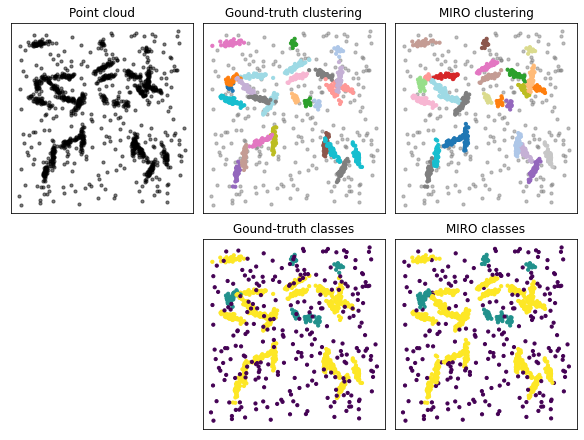

In [10]:
from functools import partial

def plot_evaluation(df):
    pos = df[["x", "y"]].to_numpy()
    cluster_gt = df["index"].to_numpy()
    cluster_pr = df["clustering-MIRO"].to_numpy()
    class_gt = df["class"].to_numpy()
    class_pr = df["class-MIRO"].to_numpy()

    def _draw_points(ax):
        ax.scatter(*pos.T, s=10, c="black", alpha=0.5)

    def _draw_clusters(ax, values):
        # noise/background
        mask_noise = values == -1
        if mask_noise.any():
            ax.scatter(
                *pos[mask_noise].T,
                s=10,
                c="gray",
                alpha=0.5,
                label="_noise",
            )
        # clusters
        mask_valid = ~mask_noise
        cmap = plt.get_cmap("tab20")
        ax.scatter(
            *pos[mask_valid].T,
            c=values[mask_valid],
            s=10,
            cmap=cmap,
        )

    def _draw_classes(ax, values):
        cmap = plt.get_cmap("viridis")
        ax.scatter(*pos.T, c=values, s=10, cmap=cmap)

    panel_funcs = [
        _draw_points,
        partial(_draw_clusters, values=cluster_gt),
        partial(_draw_clusters, values=cluster_pr),
        partial(_draw_classes, values=class_gt),
        partial(_draw_classes, values=class_pr),
    ]

    titles = [
        "Point cloud",
        "Gound-truth clustering",
        "MIRO clustering",
        "Gound-truth classes",
        "MIRO classes",
    ]

    fig, axes = plt.subplots(2, 3, figsize=(8, 6), constrained_layout=True)
    # turn off the empty subplot at (1,0)
    axes[1, 0].axis("off")

    plot_axes = [
        axes[0, 0],
        axes[0, 1],
        axes[0, 2],
        axes[1, 1],
        axes[1, 2],
    ]

    for ax, title, draw in zip(plot_axes, titles, panel_funcs):
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(title, fontsize=12)
        draw(ax)

    plt.show()

validation_image = vresults[
    vresults["set"] == np.random.choice(vresults["set"].unique())
].copy()
plot_evaluation(validation_image)